In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # to save models
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.evaluations import compute_metrics, save_report

# Reproducibility
import random
import tensorflow as tf
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
X_train = np.load("../data/X_train.npy")
X_test  = np.load("../data/X_test.npy")
y_train = np.load("../data/y_train.npy")
y_test  = np.load("../data/y_test.npy")

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes:
X_train: (398, 30)
X_test: (171, 30)
y_train: (398,)
y_test: (171,)


In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [4]:
# L1 (Manhattan)
model_L1 = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
model_L1.fit(X_train_scaled, y_train)

# L2 (Euclidean)
model_L2 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model_L2.fit(X_train_scaled, y_train)


KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [5]:
y_pred_L1 = model_L1.predict(X_test_scaled)
y_pred_L2 = model_L2.predict(X_test_scaled)



L1-NN Metrics: {'accuracy': 0.9590643274853801, 'TPR': 0.9532710280373832, 'TNR': 0.96875, 'FPR': 0.03125, 'FNR': 0.04672897196261682, 'cm': array([[ 62,   2],
       [  5, 102]], dtype=int64)}
L2-NN Metrics: {'accuracy': 0.9590643274853801, 'TPR': 0.9626168224299065, 'TNR': 0.953125, 'FPR': 0.046875, 'FNR': 0.037383177570093455, 'cm': array([[ 61,   3],
       [  4, 103]], dtype=int64)}


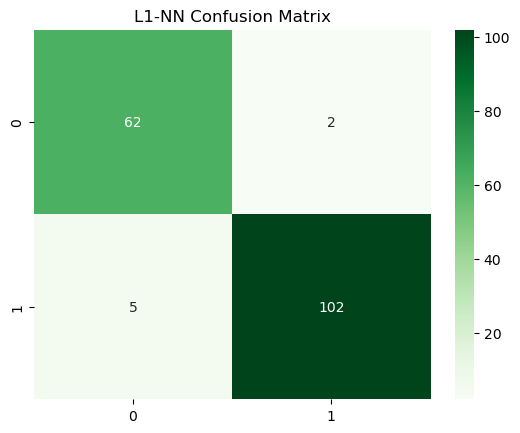

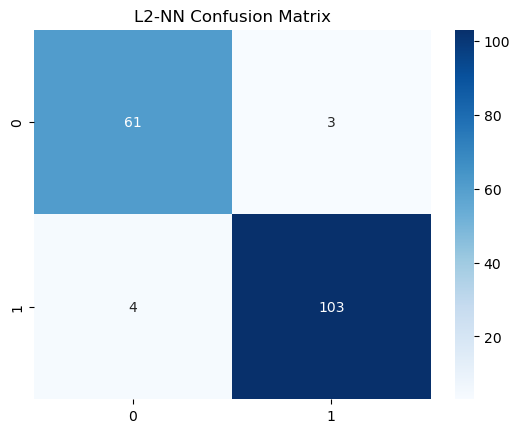

In [6]:
def compute_binary_metrics(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    acc = (TP + TN) / (TP + TN + FP + FN)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0.0
    return {"accuracy": acc, "TPR": TPR, "TNR": TNR, "FPR": FPR, "FNR": FNR, "cm": confusion_matrix(y_true, y_pred)}

metrics_L1 = compute_binary_metrics(y_test, y_pred_L1)
metrics_L2 = compute_binary_metrics(y_test, y_pred_L2)

print("L1-NN Metrics:", metrics_L1)
print("L2-NN Metrics:", metrics_L2)

# Confusion matrices
sns.heatmap(metrics_L1["cm"], annot=True, fmt='d', cmap='Greens')
plt.title("L1-NN Confusion Matrix")
plt.show()

sns.heatmap(metrics_L2["cm"], annot=True, fmt='d', cmap='Blues')
plt.title("L2-NN Confusion Matrix")
plt.show()


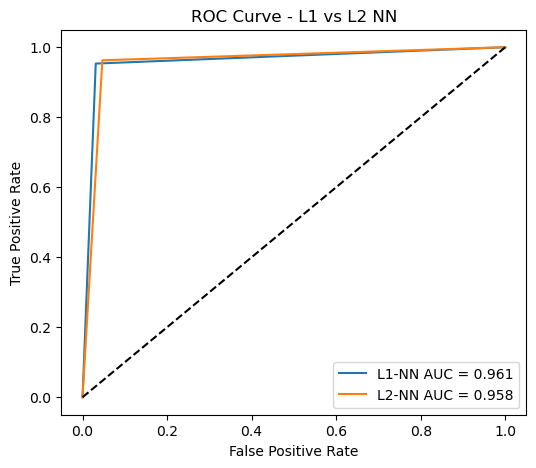

In [7]:
# Probabilities (if needed for ROC)
y_prob_L1 = model_L1.predict_proba(X_test_scaled)[:,1]
y_prob_L2 = model_L2.predict_proba(X_test_scaled)[:,1]

fpr_L1, tpr_L1, _ = roc_curve(y_test, y_prob_L1)
fpr_L2, tpr_L2, _ = roc_curve(y_test, y_prob_L2)
roc_auc_L1 = auc(fpr_L1, tpr_L1)
roc_auc_L2 = auc(fpr_L2, tpr_L2)

plt.figure(figsize=(6,5))
plt.plot(fpr_L1, tpr_L1, label=f"L1-NN AUC = {roc_auc_L1:.3f}")
plt.plot(fpr_L2, tpr_L2, label=f"L2-NN AUC = {roc_auc_L2:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - L1 vs L2 NN")
plt.legend()
plt.show()


In [8]:
# Save the models
joblib.dump(model_L1, "../saved_models/L1_KNN_model.pkl")
joblib.dump(model_L2, "../saved_models/L2_KNN_model.pkl")
print("Models saved in saved_models folder.")


Models saved in saved_models folder.


In [9]:
metrics_L1 = compute_metrics(y_test, y_pred_L1)

save_report(
    model_name="L1_NN",
    metrics=metrics_L1,
    hyperparams={
        "k": 1,
        "distance": "manhattan"
    },
    epochs=1,
    datapoints=len(y_train)
)


[OK] Report saved to: C:\Users\alaas\Project_folder_BREAST_CANCER\reports\L1_NN_report.json


In [10]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# pick a malignant sample (target == 0 in sklearn!)
i = (y == 0).nonzero()[0][0]

print("Label:", y[i])  # 0 = malignant
print(",".join(map(str, X.iloc[i].values)))


Label: 0
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [11]:
from sklearn.datasets import load_breast_cancer
import numpy as np

data = load_breast_cancer()
X = data.data
y = data.target

print("Unique labels:", np.unique(y))
print("Target names:", data.target_names)

# Show first 10 labels with meaning
for i in range(10):
    print(y[i], "→", data.target_names[y[i]])


Unique labels: [0 1]
Target names: ['malignant' 'benign']
0 → malignant
0 → malignant
0 → malignant
0 → malignant
0 → malignant
0 → malignant
0 → malignant
0 → malignant
0 → malignant
0 → malignant


In [12]:
from sklearn.datasets import load_breast_cancer
import numpy as np

data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

# Find first malignant sample (y==0)
malignant_index = np.where(y == 0)[0][0]
malignant_row = X[malignant_index]

# Find first benign sample (y==1)
benign_index = np.where(y == 1)[0][0]
benign_row = X[benign_index]

print("Malignant row:\n", malignant_row)
print("Benign row:\n", benign_row)


Malignant row:
 [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
Benign row:
 [1.354e+01 1.436e+01 8.746e+01 5.663e+02 9.779e-02 8.129e-02 6.664e-02
 4.781e-02 1.885e-01 5.766e-02 2.699e-01 7.886e-01 2.058e+00 2.356e+01
 8.462e-03 1.460e-02 2.387e-02 1.315e-02 1.980e-02 2.300e-03 1.511e+01
 1.926e+01 9.970e+01 7.112e+02 1.440e-01 1.773e-01 2.390e-01 1.288e-01
 2.977e-01 7.259e-02]


In [13]:
y_pred_prob_L2 = model_L2.predict_proba(X_test_scaled)[:, 1]
np.save("../reports/L2_KNN_y_prob.npy", y_pred_prob_L2)